In [1]:
import numpy as np
import scipy.stats as st
import pandas as pd

import matplotlib.pyplot as plt

import seaborn as sns

import properscoring

%matplotlib inline

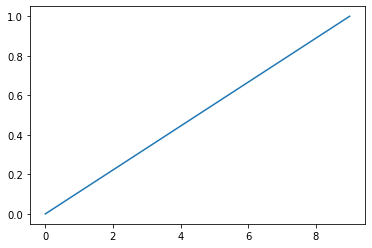

In [2]:
plt.plot(np.linspace(0, 1, 10))

In [3]:
np.random.seed(42)

# Actual distribution

In [4]:
mu_G = np.array([0, 0])
sigma_G = 1
rho_G = 0.8
cov_G = np.array([[1, rho_G], [rho_G, 1]])

def G(m):
    return np.random.multivariate_normal(mu_G, sigma_G**2 * cov_G, m)


In [5]:
#Alternative: st.multivariate_normal?

In [6]:
m = 10000
samples_G = G(m)

In [7]:
df_G = pd.DataFrame.from_records(samples_G, columns=['x', 'y'])

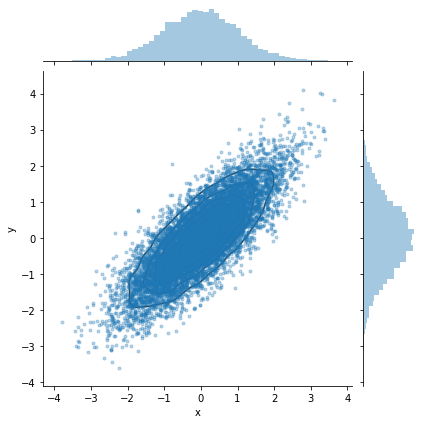

In [8]:
sns.jointplot(x="x", y="y", data=df_G, marker=".", alpha=0.3).plot_joint(sns.kdeplot, zorder=0, n_levels=6);

### Error in mean

In [9]:
mu_Fs = np.linspace(-15, 5, 10)
sigma_F = sigma_G
rho_F = 0.5

def F(m, mu, sigma, rho):
    mu_F = np.tile(mu, 2)
    sigma_F = sigma
    cov_F = np.array([[1, rho], [rho, 1]])
    df = pd.DataFrame.from_records(np.random.multivariate_normal(mu_F, sigma_F**2 * cov_F, m), 
                                   columns=['F_x', 'F_y'])
    df = df.join(pd.DataFrame.from_records(np.random.multivariate_normal(mu_F, sigma_F**2 * cov_F, m), 
                                           columns=['F_prime_x', 'F_prime_y']))
    df['mu'] = mu
    df['sigma'] = sigma
    df['sigma_err'] = 1 - sigma**2
    df['rho'] = rho
    df['G_x'] = df_G['x']
    df['G_y'] = df_G['y']
    return df


In [10]:
df_all = pd.concat([F(m, x, sigma_F, rho_F) for x in mu_Fs])

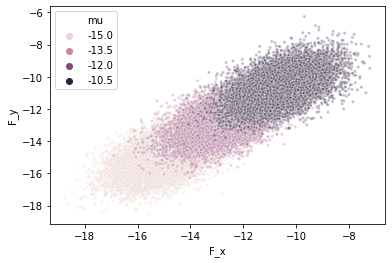

In [11]:
sns.scatterplot(x='F_x', y='F_y', hue='mu', data=df_all[df_all.mu < -10], marker=".", alpha=0.3)

In [12]:
def compute(df_all):
    df_all['err_x'] = df_all['F_x'] - df_all['G_x']
    df_all['err_y'] = df_all['F_y'] - df_all['G_y']
    df_all['rm_err'] = np.sqrt(df_all['err_x']**2 + df_all['err_y']**2)
    df_all['delta_prime_x'] = df_all['F_x'] - df_all['F_prime_x']
    df_all['delta_prime_y'] = df_all['F_y'] - df_all['F_prime_y']
    df_all['rm_delta_prime'] = np.sqrt(df_all['delta_prime_x']**2 + df_all['delta_prime_y']**2)
    return df_all

In [13]:
df_all = compute(df_all)

In [14]:
df_all.head()

,F_x,F_y,F_prime_x,F_prime_y,mu,sigma,sigma_err,rho,G_x,G_y,err_x,err_y,rm_err,delta_prime_x,delta_prime_y,rm_delta_prime
0,-15.443287,-15.159963,-15.097711,-14.085008,-15.0,1,0,0.5,-0.427501,-0.514947,-15.015785,-14.645016,20.974992,-0.345576,-1.074955,1.129137
1,-14.478742,-13.899158,-14.873650,-14.783081,-15.0,1,0,0.5,-1.096076,-0.132827,-13.382667,-13.766331,19.199157,0.394908,0.883923,0.968128
2,-13.382458,-14.036643,-15.591797,-15.650760,-15.0,1,0,0.5,0.296178,0.148097,-13.678636,-14.184740,19.705632,2.209338,1.614117,2.736156
3,-14.048052,-12.489426,-13.945991,-12.905404,-15.0,1,0,0.5,-1.740857,-1.255489,-12.307195,-11.233937,16.663385,-0.102061,0.415978,0.428315
4,-15.882914,-13.716030,-15.171242,-17.002358,-15.0,1,0,0.5,0.273810,0.616955,-16.156724,-14.332985,21.598014,-0.711672,3.286328,3.362503


In [15]:
def plot_energy_score(df_all, x='mu'):
    means = df_all.groupby(x).mean()
    means['ES'] = means['rm_err'] - 1/2* means['rm_delta_prime']
    means['ES'].plot()
    return means

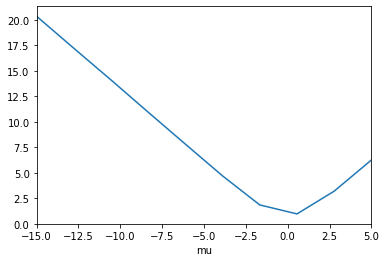

In [16]:
means = plot_energy_score(df_all, x='mu')

### Error in variance

In [17]:
mu_F = 0.
sigma_Fs = np.concatenate([np.linspace(0.1, 0.9, 9), np.linspace(1, 10, 10)])
rho_F = 0.5

In [18]:
df_all = pd.concat([F(m, mu_F, x, rho_F) for x in sigma_Fs])

In [19]:
df_all = compute(df_all)

In [20]:
#sns.scatterplot(x='F_x', y='F_y', hue='sigma', data=df_all, marker=".", alpha=0.3)

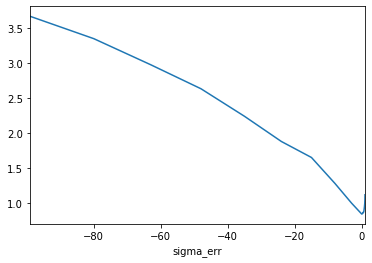

In [21]:
means = plot_energy_score(df_all, x='sigma_err')

### Error in correlation

In [22]:
mu_F = 0.
sigma_F = 1
rho_Fs = np.linspace(0, 1., 10)

In [23]:
df_all = pd.concat([F(m, mu_F, sigma_F, x) for x in rho_Fs])

In [24]:
df_all = compute(df_all)

In [25]:
#sns.scatterplot(x='F_x', y='F_y', hue='rho', data=df_all, marker=".", alpha=0.3)

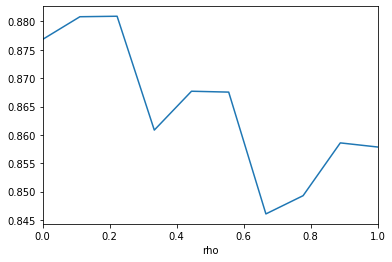

In [26]:
means = plot_energy_score(df_all, x='rho')